### Computação Quântica com Qiskit <br> Autor: Jonas Maziero

# Troca de estados quânticos

## Matriz densidade geral de 2 qubits

In [1]:
from sympy import *

In [5]:
from sympy.physics.quantum import TensorProduct
def tp(x,y):
    return TensorProduct(x,y)

In [6]:
X = Matrix([[0,1],[1,0]])
Y = Matrix([[0,-1j],[1j,0]])
Z = Matrix([[1,0],[0,-1]])
I = Matrix([[1,0],[0,1]])
xa,ya,za,xb,yb,zb = symbols('x_a y_a z_a x_b y_b z_b')
xx,xy,xz,yx,yy,yz,zx,zy,zz = symbols('xx xy xz yx yy yz zx zy zz')
rho_ab = (1/4)*(tp(I,I) + xa*tp(X,I) + ya*tp(Y,I) + za*tp(Z,I) + xb*tp(I,X) + yb*tp(I,Y) + zb*tp(I,Z))
rho_ab += (1/4)*(xx*tp(X,X) + xy*tp(X,Y) + xz*tp(X,Z) + yx*tp(Y,X) + yy*tp(Y,Y) + yz*tp(Y,Z))
rho_ab += (1/4)*(zx*tp(Z,X) + xy*tp(Z,Y) + zz*tp(Z,Z))
rho_ab

Matrix([
[       0.25*z_a + 0.25*z_b + 0.25*zz + 0.25, 0.25*x_b - 0.25*I*xy - 0.25*I*y_b + 0.25*zx, 0.25*x_a + 0.25*xz - 0.25*I*y_a - 0.25*I*yz,   0.25*xx - 0.25*I*xy - 0.25*I*yx - 0.25*yy],
[0.25*x_b + 0.25*I*xy + 0.25*I*y_b + 0.25*zx,        0.25*z_a - 0.25*z_b - 0.25*zz + 0.25,   0.25*xx + 0.25*I*xy - 0.25*I*yx + 0.25*yy, 0.25*x_a - 0.25*xz - 0.25*I*y_a + 0.25*I*yz],
[0.25*x_a + 0.25*xz + 0.25*I*y_a + 0.25*I*yz,   0.25*xx - 0.25*I*xy + 0.25*I*yx + 0.25*yy,       -0.25*z_a + 0.25*z_b - 0.25*zz + 0.25, 0.25*x_b + 0.25*I*xy - 0.25*I*y_b - 0.25*zx],
[  0.25*xx + 0.25*I*xy + 0.25*I*yx - 0.25*yy, 0.25*x_a - 0.25*xz + 0.25*I*y_a - 0.25*I*yz, 0.25*x_b - 0.25*I*xy + 0.25*I*y_b - 0.25*zx,       -0.25*z_a - 0.25*z_b + 0.25*zz + 0.25]])

In [7]:
trace(rho_ab)

1.00000000000000

## Traço, traço parcial e matriz densidade reduzida
O traço de uma matriz é a soma dos elementos em sua diagonal principal
\begin{equation}
Tr(A) = \sum_{j}A_{j,j} = \sum_{j}\langle \Psi_{j}|A|\Psi_{j}\rangle,
\end{equation}
com $\{\Psi_{j}\}$ sendo uma base qualquer do espaço onde a matriz $A$ está definida.

A função traço parcial é definida por
\begin{align}
& \rho_{a} = Tr_{b}(\rho_{ab})= \sum_{j=1}^{d_{b}}(I\otimes\langle b_{j}|)\rho_{ab}(I\otimes|b_{j}\rangle), \\
& \rho_{b} = \sum_{j=1}^{d_{a}}(\langle a_{j}|\otimes I)\rho_{ab}(|a_{j}\rangle\otimes I).
\end{align}

In [8]:
def ptraceA(da, db, rho):
    rhoB = zeros(db,db)
    for j in range(0, db):
        for k in range(0, db):
            for l in range(0, da):
                rhoB[j,k] += rho[l*db+j,l*db+k]
    return rhoB
def ptraceB(da, db, rho):
    rhoA = zeros(da,da)
    for j in range(0, da):
        for k in range(0, da):
            for l in range(0, db):
                rhoA[j,k] += rho[j*db+l,k*db+l]
    return rhoA

In [9]:
rho_a = ptraceB(2, 2, rho_ab); rho_a

Matrix([
[      0.5*z_a + 0.5, 0.5*x_a - 0.5*I*y_a],
[0.5*x_a + 0.5*I*y_a,       0.5 - 0.5*z_a]])

In [10]:
rho_b = ptraceA(2, 2, rho_ab); rho_b

Matrix([
[      0.5*z_b + 0.5, 0.5*x_b - 0.5*I*y_b],
[0.5*x_b + 0.5*I*y_b,       0.5 - 0.5*z_b]])

Ou seja
\begin{align}
& \rho_{a} = \frac{1}{2}\big(I+x_{a}X+y_{a}Y+z_{a}Z\big), \\
& \rho_{b} = \frac{1}{2}\big(I+x_{b}X+y_{b}Y+z_{b}Z\big).
\end{align}

## Aplicando a SWAP

In [12]:
def cb(n,j):
    '''retorna um vetor da base padrão de C^n'''
    vec = zeros(n,1)
    vec[j] = 1
    return vec

In [14]:
def pauli(j):
    '''retorna as matrizes de Pauli'''
    if j == 1:
        return Matrix([[0,1],[1,0]])
    elif j == 2:
        return Matrix([[0,-1j],[1j,0]])
    elif j == 3:
        return Matrix([[1,0],[0,-1]])

In [16]:
def proj(psi): 
    '''retorna o projeto no vetor psi'''
    d = psi.shape[0]
    P = zeros(d,d)
    for j in range(0,d):
        for k in range(0,d):
            P[j,k] = psi[j]*conjugate(psi[k])
    return P

In [19]:
def id(n): 
    '''retorna a matriz identidade nxn'''
    id = zeros(n,n)
    for j in range(0,n):
       id[j,j] = 1
    return id

In [20]:
CX_ab = tp(proj(cb(2,0)),id(2)) + tp(proj(cb(2,1)),pauli(1))#; CX_ab
CX_ba = tp(id(2),proj(cb(2,0))) + tp(pauli(1),proj(cb(2,1)))#; CX_ba
SWAP = CX_ab*CX_ba*CX_ab; SWAP
#SWAP = CX_ba*CX_ab*CX_ba; SWAP

Matrix([
[1, 0, 0, 0],
[0, 0, 1, 0],
[0, 1, 0, 0],
[0, 0, 0, 1]])

$$\rho_{ab}^{swap} = (SWAP)\rho_{ab}(SWAP)^{\dagger}$$

In [21]:
# aplica a troca ao estado de 2 qubits
rho_ab_swap = SWAP*rho_ab*SWAP # pois a SWAP é hermitiana

In [22]:
# verificação que a troca ocorreu
rho_a_swap = ptraceB(2, 2, rho_ab_swap); rho_a_swap

Matrix([
[      0.5*z_b + 0.5, 0.5*x_b - 0.5*I*y_b],
[0.5*x_b + 0.5*I*y_b,       0.5 - 0.5*z_b]])

In [23]:
rho_b_swap = ptraceA(2, 2, rho_ab_swap); rho_b_swap

Matrix([
[      0.5*z_a + 0.5, 0.5*x_a - 0.5*I*y_a],
[0.5*x_a + 0.5*I*y_a,       0.5 - 0.5*z_a]])

Ou seja
$$\rho_{a}^{swap}=\rho_{b} \text{ e } \rho_{b}^{swap}=\rho_{a}.$$

### Traço parcial calculado numericamente
Precisaremos dessas funções para os dados obtidos dos experimentos e simulações.

In [24]:
def pTraceL_num(dl, dr, rhoLR):
    # Returns the left partial trace over the 'left' subsystem of rhoLR
    rhoR = np.zeros((dr, dr), dtype=complex)
    for j in range(0, dr):
        for k in range(j, dr):
            for l in range(0, dl):
                rhoR[j,k] += rhoLR[l*dr+j,l*dr+k]
            if j != k:
                rhoR[k,j] = np.conj(rhoR[j,k])
    return rhoR


def pTraceR_num(dl, dr, rhoLR):
    # Returns the right partial trace over the 'right' subsystem of rhoLR
    rhoL = np.zeros((dl, dl), dtype=complex)
    for j in range(0, dl):
        for k in range(j, dl):
            for l in range(0, dr):
                rhoL[j,k] += rhoLR[j*dr+l,k*dr+l]
        if j != k:
            rhoL[k,j] = np.conj(rhoL[j,k])
    return rhoL

## Simulação e implementação experimental da troca de estados

Vamos considerar 
\begin{align}
& \rho_{a} = |0\rangle\langle 0| = \begin{bmatrix}1&0\\0&0 \end{bmatrix}, \\
& \rho_{b} = |\oplus\rangle\langle \oplus| = \begin{bmatrix}1/2&-i/2\\i/2&1/2 \end{bmatrix}.
\end{align}

### Simulação

In [43]:
from qiskit import *
qr = QuantumRegister(2)
qc = QuantumCircuit(qr)

#### Preparação dos estados

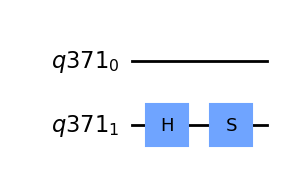

In [44]:
qc.h(qr[1])
qc.s(qr[1])
qc.draw('mpl')

##### Para a TEQ do circuito acima

In [45]:
import qiskit
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
nshots = 8192
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
simulator = Aer.get_backend('qasm_simulator')
job = qiskit.execute(qstc, backend = simulator, shots=nshots) # executa no simulador
qstf = StateTomographyFitter(job.result(), qstc) # ajusta os dados
rhoBA = qstf.fit(method='lstsq') # Note a ordem trocada que vem da função para tomografia de estados
#rhoBA # extrai o operador densidade

In [46]:
import numpy as np
rhoA = pTraceL_num(2, 2, rhoBA)
rhoA

array([[0.9971901 +0.j        , 0.00282164+0.00703214j],
       [0.00282164-0.00703214j, 0.0028099 +0.j        ]])

In [47]:
rhoB = pTraceR_num(2, 2, rhoBA)
rhoB

array([[ 0.49813916+0.j        , -0.00146047-0.49722949j],
       [-0.00146047+0.49722949j,  0.50186084+0.j        ]])

#### Fazendo o swap dos estados

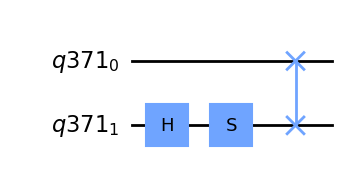

In [48]:
qc.swap(0,1)
qc.draw('mpl')

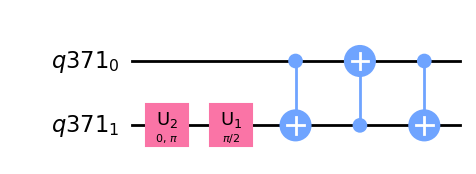

In [49]:
qc.decompose().draw('mpl')

In [50]:
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots) # executa no simulador
qstf = StateTomographyFitter(job.result(), qstc) # ajusta os dados
rhoBA = qstf.fit(method='lstsq'); # extrai o operador densidade

In [51]:
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[5.01067077e-01+0.j        , 1.54419695e-04-0.49735643j],
       [1.54419695e-04+0.49735643j, 4.98932923e-01+0.j        ]])

In [52]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[0.99730212+0.j        , 0.00685696+0.00505693j],
       [0.00685696-0.00505693j, 0.00269788+0.j        ]])

### Experimento

##### Preparação dos estados

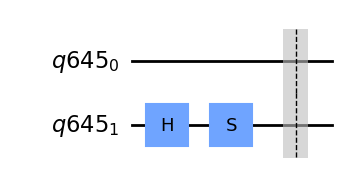

In [53]:
qr = QuantumRegister(2)
qc = QuantumCircuit(qr)
qc.h(qr[1])
qc.s(qr[1])
qc.barrier()
qc.draw('mpl')

In [81]:
qiskit.IBMQ.load_account();
provider = IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_belem')
from qiskit.tools.monitor import job_monitor

In [82]:
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, backend = device, shots = nshots)
print(job.job_id()); job_monitor(job)

61841ca06e4da211ea9b5b9e
Job Status: job has successfully run


In [83]:
qstf = StateTomographyFitter(job.result(), qstc) # ajusta os dados
rhoBA = qstf.fit(method='lstsq'); # extrai o operador densidade
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[0.99352204+0.j        , 0.02644131-0.06014646j],
       [0.02644131+0.06014646j, 0.00647796+0.j        ]])

In [84]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[0.52465211+0.j        , 0.03226595-0.48297778j],
       [0.03226595+0.48297778j, 0.47534789+0.j        ]])

##### Troca dos estados

In [54]:
qc.swap(qr[0],qr[1])

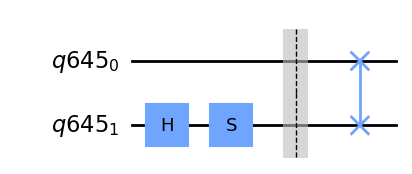

In [55]:
qc.draw('mpl')

In [91]:
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, backend = device, shots = nshots)
print(job.job_id()); job_monitor(job)

61841d516e4da2c4c09b5bad
Job Status: job has successfully run


In [92]:
qstf = StateTomographyFitter(job.result(), qstc) # ajusta os dados
rhoBA = qstf.fit(method='lstsq'); # extrai o operador densidade
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[0.51277093+0.j       , 0.0100801 -0.4409531j],
       [0.0100801 +0.4409531j, 0.48722907+0.j       ]])

In [93]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[0.93142851+0.j       , 0.03019276-0.0574553j],
       [0.03019276+0.0574553j, 0.06857149+0.j       ]])